В ходе данной задачи необходимо проанализировать данные банка и на основании исторических данных построить модель, которая предсказывает, уйдет ли клиент из банка. 

Сначала была проведена предобработка данных, разбиение на обучающую, валидирующую и тестовую выборки. 

Сначала проводилось обучение моделей без учета дисбаланса классов - получены предсказания для модели случайного леса и логистической регрессии. Затем были использованы методы компенсации дисбаланса - upsampling и downsampling.

После выбора наилучшей модели были получены предсказания для тестовой выборки и оценено финальное качество модели.

## Подготовка данных

In [ ]:
#загрузим необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
!pip install scikit-learn==1.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 37.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install imblearn


Загрузим датасет, рассмотрим описание данных.

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Можем видеть, что 20% клиентов ушли из банка.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Как видно из описания выше, в датасете присутствуют пропуски в столбце Tenure, который отвечает за то, сколько лет человек является клиентом банка. Заменим значение на медианное с учетом того, остался ли человек клиентом банка.

In [ ]:
df.loc[df['Exited']==0]['Tenure'].median()

5.0

In [ ]:
df.loc[df['Exited']==1]['Tenure'].median()

5.0

Так как медианные значения равны, то можем просто заполнить пропуски.

In [ ]:
df.fillna(5.0, inplace=True)

Проверим заполнение пропусков:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Построим графики, чтобы посмотреть, есть ли корреляция в данных.

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', "EstimatedSalary", 'Exited']

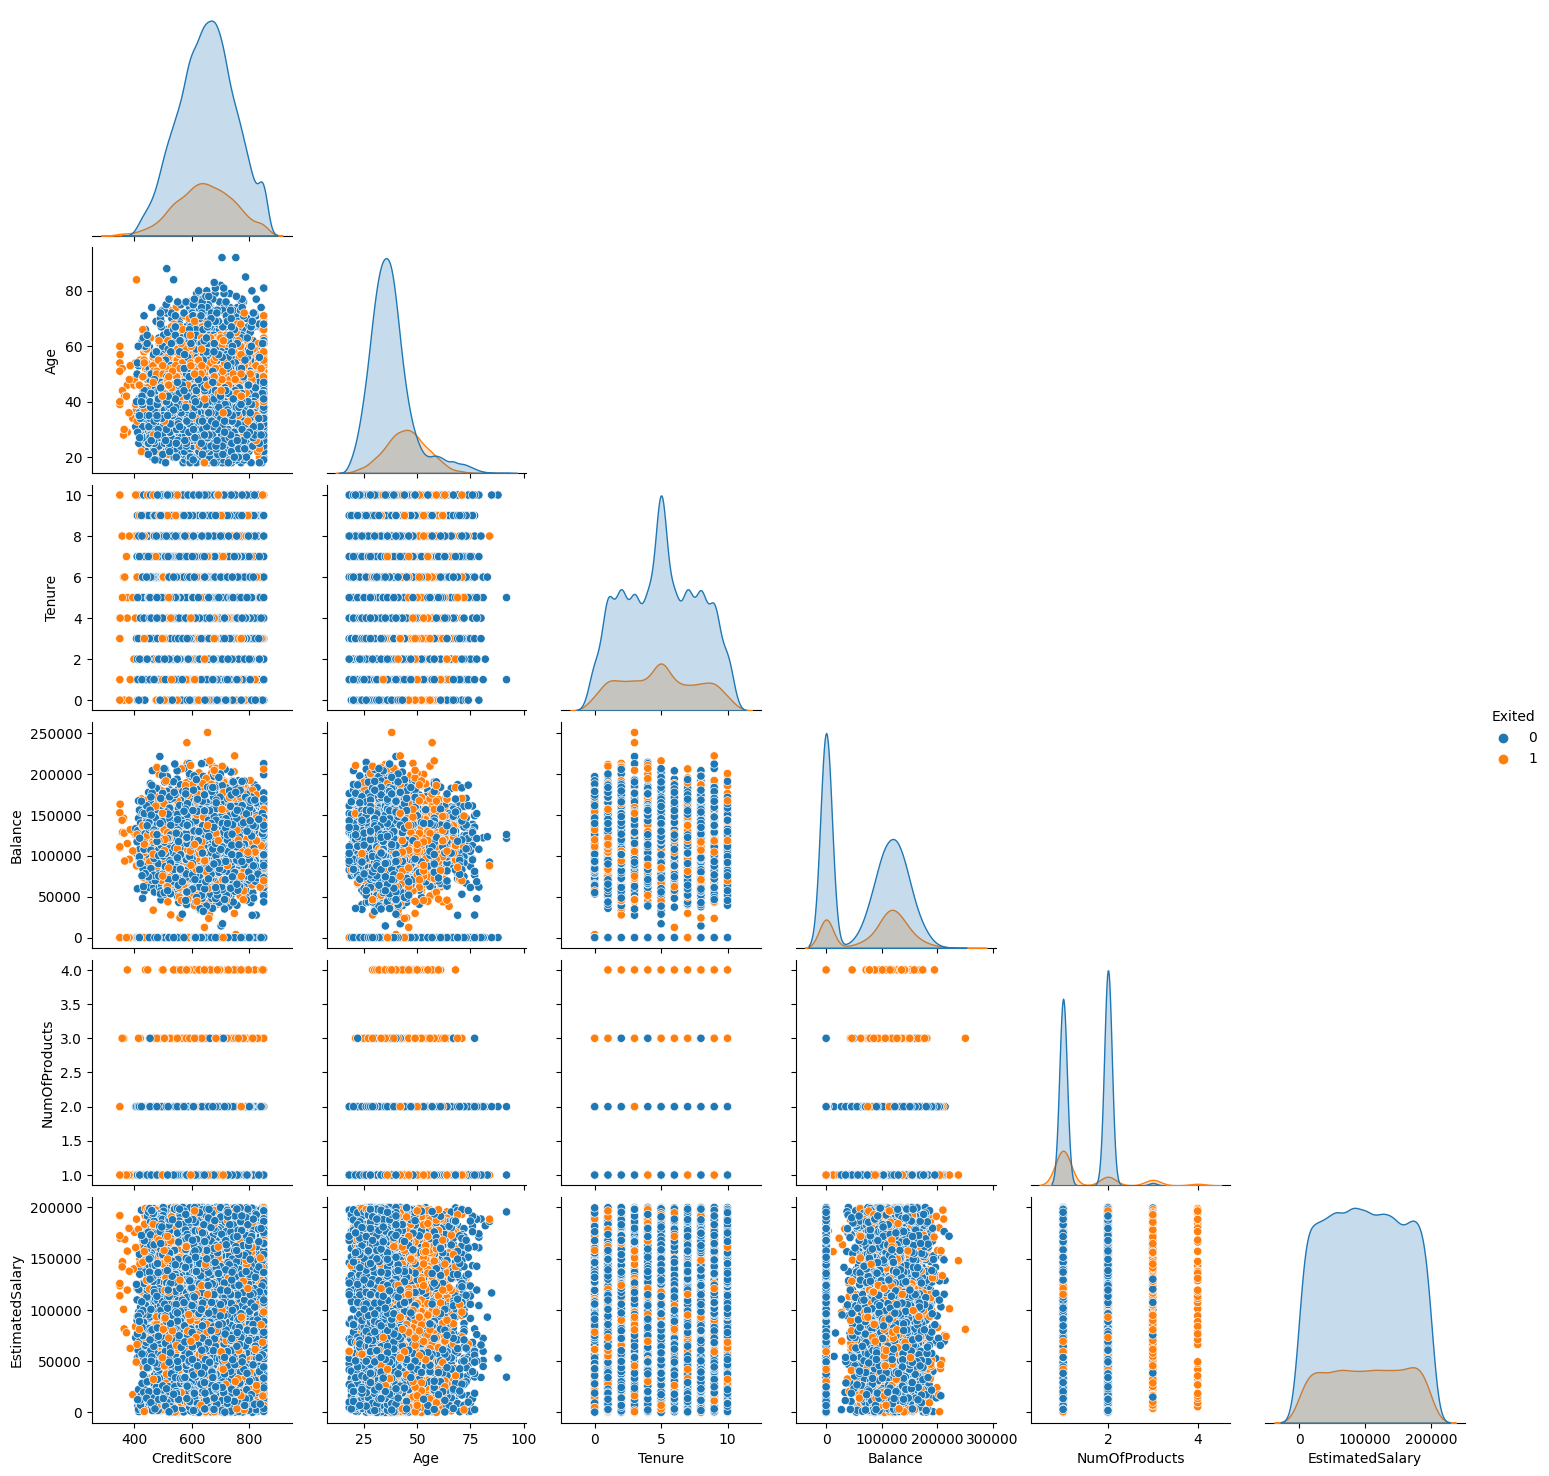

In [ ]:
sns.pairplot(df[numeric], hue='Exited', corner = True);

Очевидной корреляции между вещественными и дискретными признаками нет. 

Не все из предоставленных признаков будем рассматривать при построении модели - так, фамилия или id - высокоспецифичные значения, которые вряд ли имеют предсказательную силу.

CreditScore — кредитный рейтинг

Geography — страна проживания - необходимо закодировать признак

Gender — пол 

Age — возраст 

Tenure — сколько лет человек является клиентом банка 

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты 

IsActiveMember — активность клиента 

EstimatedSalary — предполагаемая зарплата









Создадим новый датасет с необходимыми признаками и закодируем страну с помощью OneHotEncoding. 

In [ ]:
data = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [ ]:
#data = pd.get_dummies(data, drop_first=True)

In [ ]:
data.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [ ]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Видим, что есть люди с нулевым балансом. Посчитаем, сколько их.

In [ ]:
print(data.loc[data['Balance']==0.0]['Balance'].count())

3617


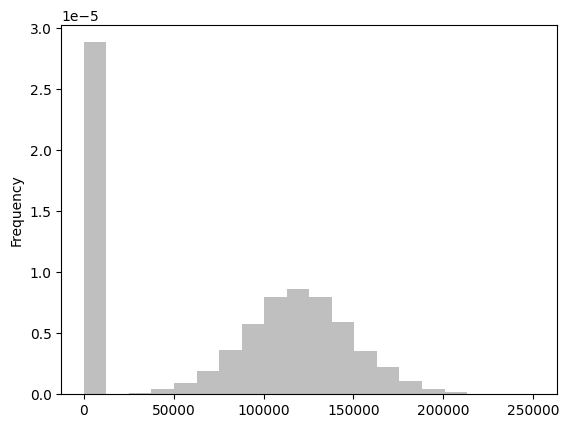

In [ ]:
data['Balance'].plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey');

Примерно треть. Стоит узнать, что именно означает нулевой баланс на счете. 

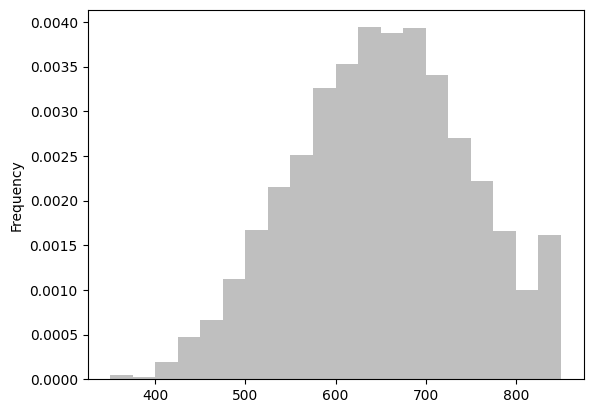

In [ ]:
data['CreditScore'].plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey');

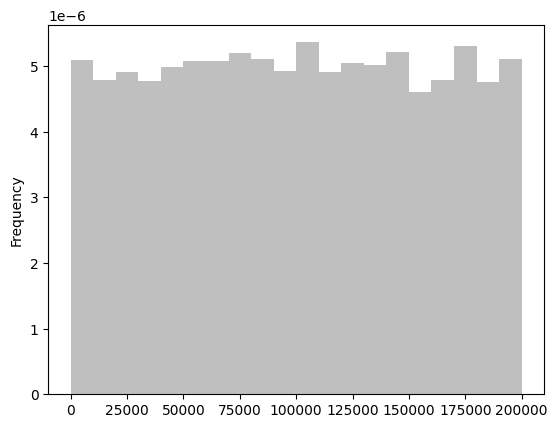

In [ ]:
data['EstimatedSalary'].plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey');

Другие выводы по данным: 



*   Примерно 70% имеют кредитную карту
*   50% являются активными клиентами
*   Некоторые значения зарплат, вероятно, неправильно записаны, но распределение зарплат равномерное, неочевидно, как проводить границу
* В Германии и Испании живут по 25% людей, оставшаяся половина - во Франции
*   Мужчин и женщин среди клиентов примерно поровну
*   Credit Score имеет неестественный пик, который портит "нормальность" распределения 


---


* 20% клиентов покинули банк
 


Данные предобработаны - они не содержат выбросов и типы данных в столбцах подходят для дальнейших манипуляций.

Поделим данные на обучающую, валидационную и тестовые выборки так, чтобы размер составлял 70:15:15.

In [ ]:
features = data.drop('Exited', axis = 1)
target = data['Exited']

In [ ]:
features_train, features_val_test, target_train, target_val_test = train_test_split(
    features, target, test_size=0.3, random_state=42)
features_val, features_test, target_val, target_test = train_test_split(
    features_val_test, target_val_test, test_size=0.5, random_state=42)

In [ ]:
#проверим размер выборок

print(features_train.shape)

print(features_val.shape)

print(features_test.shape)

print(target_train.shape)

print(target_val.shape)

print(target_test.shape)

(7000, 10)
(1500, 10)
(1500, 10)
(7000,)
(1500,)
(1500,)


Закодируем представленные категориальные признаки с помощью OHE-encoding.

In [ ]:
ohe_columns = ['Geography', 'Gender']

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_columns])



OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [ ]:
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_columns])


In [ ]:
features_train = features_train.drop(ohe_columns, axis=1)

In [ ]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9069,619,32,4.0,175406.13,2,1,1,172792.43,0.0,1.0,0.0
2603,643,34,5.0,160426.07,1,0,1,188533.11,1.0,0.0,0.0
7738,561,33,6.0,0.00,2,0,0,173680.39,0.0,0.0,1.0
1579,618,41,8.0,37702.79,1,1,1,195775.48,1.0,0.0,1.0
5058,714,37,9.0,148466.93,2,0,1,151280.96,0.0,0.0,1.0


In [ ]:
features_val[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_val[ohe_columns])

features_val = features_val.drop(ohe_columns, axis=1)

In [ ]:
features_val.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8127,651,35,8.0,110067.71,1,1,0,127678.95,1.0,0.0,1.0
4321,651,34,4.0,91562.99,1,1,1,123954.15,0.0,0.0,1.0
450,494,38,7.0,174937.64,1,1,0,40084.32,1.0,0.0,0.0
5798,732,54,0.0,134249.70,1,0,1,13404.40,0.0,1.0,1.0
5181,661,35,5.0,128415.45,1,1,0,142626.49,0.0,1.0,0.0


In [ ]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_columns])

features_test = features_test.drop(ohe_columns, axis=1)

In [ ]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2697,723,48,7.0,0.00,2,1,1,150694.58,0.0,0.0,1.0
6871,636,48,3.0,120568.41,1,1,0,190160.04,1.0,0.0,0.0
3487,671,31,7.0,41299.03,1,0,1,102681.32,0.0,0.0,0.0
92,524,36,10.0,0.00,2,1,0,109614.57,0.0,0.0,0.0
9537,783,40,6.0,0.00,2,1,0,109742.55,0.0,0.0,1.0


## Обучение без учета дисбаланса классов

Протестируем модель случайного леса и подберем гиперпараметры. Рассмотрим 3 предлагаемых критерия расчета функции потерь, а также переберем число деревьев в лесу от 1 до 50 и сохраним лучшую модель.

### Расчет всех моделей

In [ ]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
#crit = ['gini', 'entropy', 'log_loss']
for est in range(1, 101, 10):
    for i in range(1,21):
        rf_model = RandomForestClassifier(random_state=42, n_estimators=est, criterion='entropy', max_depth=i) 
        rf_model.fit(features_train, target_train) 
        pred = rf_model.predict(features_val)
        result = f1_score(target_val, pred) 
        print('Число деревьев: ', est, '. Глубина дерева - ', i, '. Результат - ', result, sep ='')
        if result > best_result:
            best_model = rf_model
            best_est = est
            best_depth = i 
            best_result = result 

Число деревьев: 1. Глубина дерева - 1. Результат - 0.0
Число деревьев: 1. Глубина дерева - 2. Результат - 0.16025641025641024
Число деревьев: 1. Глубина дерева - 3. Результат - 0.23493975903614459
Число деревьев: 1. Глубина дерева - 4. Результат - 0.4781704781704782
Число деревьев: 1. Глубина дерева - 5. Результат - 0.4285714285714286
Число деревьев: 1. Глубина дерева - 6. Результат - 0.42685851318944845
Число деревьев: 1. Глубина дерева - 7. Результат - 0.4571428571428572
Число деревьев: 1. Глубина дерева - 8. Результат - 0.4736842105263158
Число деревьев: 1. Глубина дерева - 9. Результат - 0.4780701754385964
Число деревьев: 1. Глубина дерева - 10. Результат - 0.48627450980392156
Число деревьев: 1. Глубина дерева - 11. Результат - 0.50390625
Число деревьев: 1. Глубина дерева - 12. Результат - 0.48771266540642716
Число деревьев: 1. Глубина дерева - 13. Результат - 0.46953405017921146
Число деревьев: 1. Глубина дерева - 14. Результат - 0.5054945054945056
Число деревьев: 1. Глубина дерев

### Характеристики лучшей модели

In [ ]:
print('Лучшая модель:')
print('Число деревьев: ', best_est, '. Глубина - ', best_depth, '. Результат f1 - ', best_result, sep ='')

Лучшая модель:
Число деревьев: 11. Глубина - 14. Результат f1 - 0.6085106382978724


In [ ]:
pred = best_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

Результат roc_auc =  0.8382308654558933


In [ ]:
best_model = RandomForestClassifier (random_state=42, n_estimators=11, criterion='entropy', max_depth=14) 

### Логистическая регрессия

Посмотрим, как показывает себя логистическая регрессия.

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
for j in solvers:
    model = LogisticRegression(random_state=42, solver=j, max_iter=1000)
    model.fit(features_train, target_train)
    pred = model.predict(features_val)
    f1 = f1_score(target_val, pred)
    print('solver = ', j, ', accuracy = ', f1)

/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


solver =  newton-cg , accuracy =  0.2879581151832461
solver =  lbfgs , accuracy =  0.125
solver =  liblinear , accuracy =  0.1411764705882353


Видим, что f1 значительно ниже, чем для случайного леса, что объясняется простотой модели.


## Обучение с учетом дисбаланса классов

### Downsampling

Переберем возможные значения доли исходной выборки, которая будет обработана, найдем оптимальное.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat( [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
    return features_downsampled, target_downsampled


In [ ]:
#for i in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#    features_downsampled, target_downsampled = downsample(features_train, target_train, i)
#    model = best_model
#    model.fit(features_downsampled, target_downsampled)
#    predicted_valid = model.predict(features_val)
#    print('i =', i)
#    print("F1:", f1_score(target_val, predicted_valid))

i = 0.05
F1: 0.38004101161995896
i = 0.1
F1: 0.44905008635578575
i = 0.15
F1: 0.4911917098445596
i = 0.2
F1: 0.5233219567690558
i = 0.3
F1: 0.5522174535050071
i = 0.4
F1: 0.5636672325976231
i = 0.5
F1: 0.5964285714285714
i = 0.6
F1: 0.5864077669902913
i = 0.7
F1: 0.5887096774193549
i = 0.8
F1: 0.5950413223140496
i = 0.9
F1: 0.579520697167756


In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
model = best_model
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_val)
print("F1:", f1_score(target_val, predicted_valid))

F1: 0.5316129032258065


In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.8)
model = best_model
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_val)
print("F1:", f1_score(target_val, predicted_valid))

F1: 0.6048387096774193


In [ ]:
#features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)
#model = best_model
#model.fit(features_downsampled, target_downsampled)
#predicted_valid = model.predict(features_val)
#best_down_model = model

#print("F1:", f1_score(target_val, predicted_valid))

#pred = best_down_model.predict_proba(features_val)
#print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.5964285714285714
Результат roc_auc =  0.8428552399925873


### Upsampling

Аналогично рассмотрим различные параметры для умножения более редкого класса.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [ ]:
#for i in range(2,15):
#    features_upsampled, target_upsampled = upsample(features_train, target_train, i)
#    model = best_model
#    model.fit(features_upsampled, target_upsampled)
#    predicted_valid = model.predict(features_val)
#    print('i =', i)
#    print("F1:", f1_score(target_val, predicted_valid))

i = 2
F1: 0.5673469387755102
i = 3
F1: 0.5905511811023622
i = 4
F1: 0.58984375
i = 5
F1: 0.5930232558139534
i = 6
F1: 0.5669902912621358
i = 7
F1: 0.578125
i = 8
F1: 0.5752895752895754
i = 9
F1: 0.5748031496062992
i = 10
F1: 0.5811320754716982
i = 11
F1: 0.5730994152046784
i = 12
F1: 0.5764023210831721
i = 13
F1: 0.5912698412698413
i = 14
F1: 0.5870841487279843


In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
model = best_model
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_val)
best_up_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_up_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))



F1: 0.5738255033557047
Результат roc_auc =  0.8350992054299482


### SMOTE

Попробуем SMOTE без гиперпараметров

In [ ]:
sm = SMOTE(random_state=42)
f_res, t_res = sm.fit_resample(features_train, target_train)
model = best_model
model.fit(f_res, t_res)
predicted_valid = model.predict(features_val)
best_sm_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_sm_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.5641952983725136
Результат roc_auc =  0.8281713306152705


Изменим тип семплирования:

In [ ]:
sm = SMOTE(random_state=42, sampling_strategy='not minority')
f_res, t_res = sm.fit_resample(features_train, target_train)
model = best_model
model.fit(f_res, t_res)
predicted_valid = model.predict(features_val)
best_sm_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_sm_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.6085106382978724
Результат roc_auc =  0.8382308654558933


In [ ]:
sm = SMOTE(random_state=42, sampling_strategy=0.4)
f_res, t_res = sm.fit_resample(features_train, target_train)
model = best_model
model.fit(f_res, t_res)
predicted_valid = model.predict(features_val)
best_sm_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_sm_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.5931863727454911
Результат roc_auc =  0.8251381231467754


### UnderSampler

Здесь также попробуем разные типы семплирования:

In [ ]:
rus = RandomUnderSampler(random_state=42)
f_res, t_res = rus.fit_resample(features_train, target_train)
model = best_model
model.fit(f_res, t_res)
predicted_valid = model.predict(features_val)
best_us_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_us_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.5391766268260293
Результат roc_auc =  0.8321630026871756


In [ ]:
rus = RandomUnderSampler(random_state=42, sampling_strategy='not majority')
f_res, t_res = rus.fit_resample(features_train, target_train)
model = best_model
model.fit(f_res, t_res)
predicted_valid = model.predict(features_val)
best_us_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_us_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.5548387096774193
Результат roc_auc =  0.8272765706078575


In [ ]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
f_res, t_res = rus.fit_resample(features_train, target_train)
model = best_model
model.fit(f_res, t_res)
predicted_valid = model.predict(features_val)
best_us_model = model
print("F1:", f1_score(target_val, predicted_valid))

pred = best_us_model.predict_proba(features_val)
print('Результат roc_auc = ', roc_auc_score(target_val, pred[:, 1]))

F1: 0.599290780141844
Результат roc_auc =  0.8292962958673091


## Тестирование

Наилучший f1-score показала модель RandomForest с число деревьев 11 и глубиной 14. Для учета дисбаланса классов использовался SMOTE с параметром ресемплинга 0.4. F1 такого сочетания методов: 0.5931863727454911.


Исходя из постановки задачи, мы можем предположить, что для нас важнее правильно определить положительный класс - ушедших клиентов, поэтому большее внимание стоит уделять f1-score.

In [ ]:
pred = best_sm_model.predict(features_test)
print("F1:", f1_score(target_test, pred))

pred = best_sm_model.predict_proba(features_test)
print('Результат roc_auc = ', roc_auc_score(target_test, pred[:, 1]))

F1: 0.5917355371900826
Результат roc_auc =  0.8490194444444444


Построим график ROC.

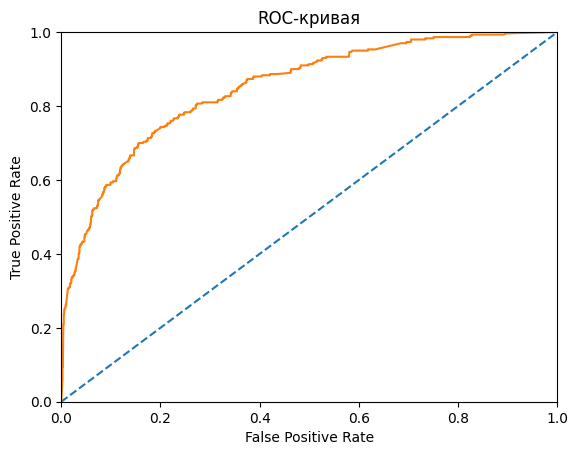

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, pred[:, 1]) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.plot(fpr, tpr)
plt.show()

### Baseline

<br/>
<div class="alert alert-info">
Добавила новый раздел
</div>
    

In [ ]:
dummy_model = DummyClassifier(strategy='constant', constant=1) 
dummy_model.fit(features_train, target_train) 
print('F1-score dummy-модели:', f1_score(dummy_model.predict(features_test), target_test))

F1-score dummy-модели: 0.33333333333333337


## Вывод

В ходе работы была проведена предобработка данных - заполнение пропусков, отбор необходимых признаков - затем были применены методы классификации с подбором гиперпараметров. Были определены лучшие значения гиперпараметров и на них были получены предсказания для тестовой выборки.

Для оценки качества модели использовались метрики f1 и roc_auc. 

Наилучший f1-score показала модель RandomForest с число деревьев 11 и глубиной 14. Для учета дисбаланса классов использовался SMOTE с параметром ресемплинга 0.4. F1 такого сочетания методов: 0.5931863727454911.

Результаты модели на тестовых данных: 

F1: 0.5917355371900826

ROC-AUC:  0.8490194444444444

Результаты dummy-модели:

F1-score: 0.33333333333333337